# F1 Machine Learning Pipeline
## Gradient Boosting + Random Forest for Race Predictions

This notebook demonstrates the complete ML pipeline for predicting F1 race results including:
- Qualifying predictions
- Sprint predictions
- Race result predictions

Models: Gradient Boosting Regressor + Random Forest Regressor

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src directory to path
sys.path.append('../src')

from data_fetcher import F1DataFetcher
from database import F1Database
from telemetry_handler import TelemetryHandler
from ml_models import F1PredictionModel

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Data Collection and Preparation

In [2]:
# Initialize components
fetcher = F1DataFetcher()
db = F1Database()
telemetry_handler = TelemetryHandler()

print("✓ Components initialized")
print(f"Database: {db.db_path}")
print(f"Cache: {fetcher.cache_dir}")
print(f"Telemetry: {telemetry_handler.telemetry_dir}")

✓ Database initialized at E:\Formula_1_db\notebooks\..\f1_data.db
✓ Components initialized
Database: E:\Formula_1_db\notebooks\..\f1_data.db
Cache: E:\Formula_1_db\notebooks\..\cache
Telemetry: E:\Formula_1_db\notebooks\..\telemetry_data


In [3]:
# Fetch 2024 season schedule
schedule_2024 = fetcher.fetch_season_schedule(2024)

if schedule_2024 is not None:
    print(f"\n2024 Season: {len(schedule_2024)} events")
    display(schedule_2024[['EventName', 'EventDate', 'Country', 'Location']].head(10))
else:
    print("Unable to fetch 2024 schedule")

Fetched schedule for 2024 season: 25 events

2024 Season: 25 events


,EventName,EventDate,Country,Location
0,Pre-Season Testing,2024-02-23,Bahrain,Sakhir
1,Bahrain Grand Prix,2024-03-02,Bahrain,Sakhir
2,Saudi Arabian Grand Prix,2024-03-09,Saudi Arabia,Jeddah
3,Australian Grand Prix,2024-03-24,Australia,Melbourne
4,Japanese Grand Prix,2024-04-07,Japan,Suzuka
5,Chinese Grand Prix,2024-04-21,China,Shanghai
6,Miami Grand Prix,2024-05-05,United States,Miami
7,Emilia Romagna Grand Prix,2024-05-19,Italy,Imola
8,Monaco Grand Prix,2024-05-26,Monaco,Monaco
9,Canadian Grand Prix,2024-06-09,Canada,Montréal


## 2. Feature Engineering

Create features for ML models based on historical performance

In [4]:
def create_training_data(years=[2023, 2024], num_races=5):
    """
    Create synthetic training data for demonstration
    In production, this would pull from actual race results
    """
    np.random.seed(42)
    
    drivers = range(1, 21)  # 20 drivers
    data_list = []
    
    for year in years:
        for race in range(1, num_races + 1):
            for driver in drivers:
                # Simulate driver performance characteristics
                base_skill = np.random.uniform(5, 15)  # Base driver skill
                team_factor = np.random.uniform(0.7, 1.3)  # Team strength
                
                data_list.append({
                    'year': year,
                    'race': race,
                    'driver_number': driver,
                    'driver_avg_position': base_skill + np.random.normal(0, 2),
                    'driver_recent_form': base_skill + np.random.normal(0, 3),
                    'team_avg_position': base_skill * team_factor + np.random.normal(0, 1),
                    'qualifying_position': np.random.randint(1, 21),
                    'grid_position': np.random.randint(1, 21),
                    'track_experience': np.random.randint(0, 10),
                    'points_before_race': np.random.uniform(0, 400),
                })
    
    df = pd.DataFrame(data_list)
    
    # Create target: race position
    df['race_position'] = (
        0.35 * df['qualifying_position'] +
        0.25 * df['driver_avg_position'] +
        0.20 * df['team_avg_position'] +
        0.10 * df['driver_recent_form'] +
        np.random.normal(0, 2, len(df))
    ).clip(1, 20).round(0)
    
    return df

# Create training data
training_data = create_training_data(years=[2023, 2024], num_races=10)

print(f"Training data shape: {training_data.shape}")
print(f"\nSample data:")
display(training_data.head(10))

# Statistics
print("\nData Statistics:")
display(training_data.describe())

Training data shape: (400, 11)

Sample data:


,year,race,driver_number,driver_avg_position,driver_recent_form,team_avg_position,qualifying_position,grid_position,track_experience,points_before_race,race_position
0,2023,1,1,10.040778,13.314491,10.876254,11,11,7,133.483444,8.0
1,2023,1,2,5.960394,6.668164,6.851159,6,2,4,246.992604,9.0
2,2023,1,3,11.160975,9.833153,7.296886,16,15,2,152.984797,13.0
3,2023,1,4,14.597358,16.083342,15.368981,9,7,1,379.554215,11.0
4,2023,1,5,13.455043,13.781239,16.766596,7,12,7,13.755408,13.0
5,2023,1,6,17.797760,10.297847,13.145459,6,10,3,73.941782,8.0
6,2023,1,7,16.172779,15.209951,17.006184,16,13,1,215.876853,13.0
7,2023,1,8,10.265304,6.337640,14.622715,15,13,0,6.254563,10.0
8,2023,1,9,10.506625,6.513853,9.127658,10,7,9,46.347624,8.0
9,2023,1,10,16.238357,12.193512,14.453784,5,3,7,109.888717,8.0



Data Statistics:


,year,race,driver_number,driver_avg_position,driver_recent_form,team_avg_position,qualifying_position,grid_position,track_experience,points_before_race,race_position
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,2023.500000,5.500000,10.500000,10.226830,10.159098,9.848727,10.675000,10.605000,4.335000,196.464362,9.242500
std,0.500626,2.875878,5.773503,3.652540,4.138244,3.585551,5.789488,5.722398,2.918745,109.655707,3.327367
min,2023.000000,1.000000,1.000000,-1.381377,-2.723149,1.960975,1.000000,1.000000,0.000000,0.411792,1.000000
25%,2023.000000,3.000000,5.750000,7.458450,7.097549,7.070805,6.000000,5.750000,2.000000,103.129633,7.000000
50%,2023.500000,5.500000,10.500000,10.311137,10.325922,9.836771,10.000000,11.000000,4.000000,203.331387,9.000000
75%,2024.000000,8.000000,15.250000,13.011816,13.004949,12.224469,16.000000,15.250000,7.000000,279.594971,11.000000
max,2024.000000,10.000000,20.000000,20.316424,21.684090,19.029432,20.000000,20.000000,9.000000,396.993401,19.000000


## 3. Train Models

### 3.1 Race Position Prediction

In [5]:
# Initialize model
race_model = F1PredictionModel()

# Prepare features and target
X = race_model.prepare_features(training_data)
y = training_data['race_position']

print(f"Features: {race_model.feature_names}")
print(f"Training samples: {len(X)}")

# Train ensemble
race_model.train_ensemble(X, y, test_size=0.2)

Features: ['driver_avg_position', 'driver_recent_form', 'team_avg_position', 'grid_position', 'qualifying_position', 'track_experience', 'points_before_race']
Training samples: 400

Training Ensemble Models

Training Gradient Boosting model...
✓ Gradient Boosting model trained

Training Random Forest model...
✓ Random Forest model trained

Model Evaluation

Gradient Boosting:
  MAE: 1.989
  R² Score: 0.421

Random Forest:
  MAE: 1.913
  R² Score: 0.482

Ensemble (Average):
  MAE: 1.942
  R² Score: 0.460


(GradientBoostingRegressor(max_depth=5, random_state=42),
 RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42))

### 3.2 Qualifying Position Prediction

In [6]:
# Create qualifying-specific data
qualifying_data = training_data.copy()
qualifying_data['quali_position'] = qualifying_data['qualifying_position']

# Initialize qualifying model
quali_model = F1PredictionModel()

# Prepare features (excluding qualifying_position for qualifying prediction)
quali_features = training_data[[
    'driver_avg_position', 'driver_recent_form', 'team_avg_position',
    'track_experience', 'points_before_race'
]].copy()
quali_features['grid_position'] = training_data['grid_position']  # Previous race result proxy
quali_features['qualifying_position'] = training_data['race_position']  # Placeholder

quali_model.feature_names = quali_features.columns.tolist()
y_quali = qualifying_data['quali_position']

# Train qualifying models
print("\nTraining Qualifying Prediction Models")
quali_model.train_ensemble(quali_features, y_quali, test_size=0.2)


Training Qualifying Prediction Models

Training Ensemble Models

Training Gradient Boosting model...
✓ Gradient Boosting model trained

Training Random Forest model...
✓ Random Forest model trained

Model Evaluation

Gradient Boosting:
  MAE: 4.112
  R² Score: 0.116

Random Forest:
  MAE: 3.735
  R² Score: 0.303

Ensemble (Average):
  MAE: 3.877
  R² Score: 0.227


(GradientBoostingRegressor(max_depth=5, random_state=42),
 RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42))

### 3.3 Sprint Race Prediction

In [7]:
# Create sprint-specific data
sprint_data = training_data.copy()
sprint_data['sprint_position'] = (
    0.4 * sprint_data['qualifying_position'] +
    0.3 * sprint_data['driver_recent_form'] +
    0.2 * sprint_data['team_avg_position'] +
    np.random.normal(0, 2, len(sprint_data))
).clip(1, 20).round(0)

# Initialize sprint model
sprint_model = F1PredictionModel()

X_sprint = sprint_model.prepare_features(sprint_data)
y_sprint = sprint_data['sprint_position']

# Train sprint models
print("\nTraining Sprint Prediction Models")
sprint_model.train_ensemble(X_sprint, y_sprint, test_size=0.2)


Training Sprint Prediction Models

Training Ensemble Models

Training Gradient Boosting model...
✓ Gradient Boosting model trained

Training Random Forest model...
✓ Random Forest model trained

Model Evaluation

Gradient Boosting:
  MAE: 1.754
  R² Score: 0.539

Random Forest:
  MAE: 1.696
  R² Score: 0.604

Ensemble (Average):
  MAE: 1.691
  R² Score: 0.588


(GradientBoostingRegressor(max_depth=5, random_state=42),
 RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42))

## 4. Feature Importance Analysis

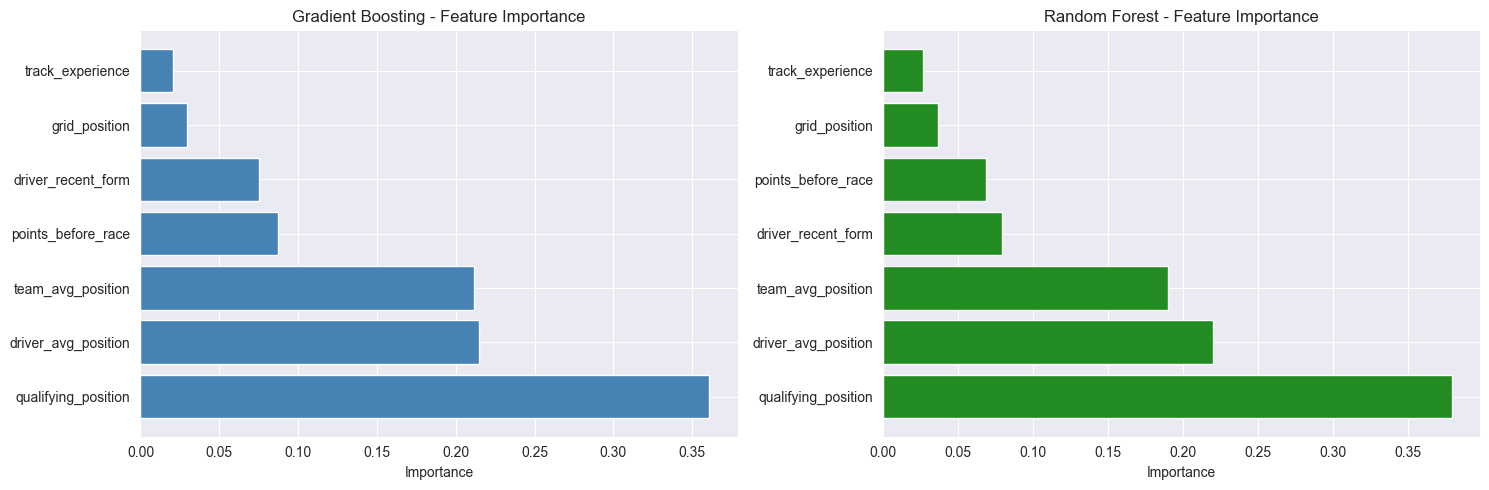


Feature Importance Rankings:

Gradient Boosting:
  qualifying_position: 0.3607
  driver_avg_position: 0.2150
  team_avg_position: 0.2118
  points_before_race: 0.0873
  driver_recent_form: 0.0750
  grid_position: 0.0294
  track_experience: 0.0208

Random Forest:
  qualifying_position: 0.3789
  driver_avg_position: 0.2198
  team_avg_position: 0.1898
  driver_recent_form: 0.0791
  points_before_race: 0.0686
  grid_position: 0.0370
  track_experience: 0.0267


In [8]:
# Plot feature importance for race model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gradient Boosting importance
gb_importance = race_model.get_feature_importance('gradient_boosting')
gb_features = [x[0] for x in gb_importance]
gb_values = [x[1] for x in gb_importance]

axes[0].barh(gb_features, gb_values, color='steelblue')
axes[0].set_title('Gradient Boosting - Feature Importance')
axes[0].set_xlabel('Importance')

# Random Forest importance
rf_importance = race_model.get_feature_importance('random_forest')
rf_features = [x[0] for x in rf_importance]
rf_values = [x[1] for x in rf_importance]

axes[1].barh(rf_features, rf_values, color='forestgreen')
axes[1].set_title('Random Forest - Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("\nFeature Importance Rankings:")
print("\nGradient Boosting:")
for feature, importance in gb_importance:
    print(f"  {feature}: {importance:.4f}")

print("\nRandom Forest:")
for feature, importance in rf_importance:
    print(f"  {feature}: {importance:.4f}")

## 5. Make Predictions for 2026 Season

In [9]:
def create_2026_prediction_data():
    """Create sample data for 2026 predictions"""
    drivers = range(1, 21)
    data_list = []
    
    for driver in drivers:
        # Extrapolate from historical data
        data_list.append({
            'driver_number': driver,
            'driver_avg_position': np.random.uniform(5, 15),
            'driver_recent_form': np.random.uniform(5, 15),
            'team_avg_position': np.random.uniform(5, 12),
            'qualifying_position': np.random.randint(1, 21),
            'grid_position': np.random.randint(1, 21),
            'track_experience': np.random.randint(0, 15),
            'points_before_race': np.random.uniform(0, 450),
        })
    
    return pd.DataFrame(data_list)

# Create 2026 data
data_2026 = create_2026_prediction_data()

print("2026 Season Prediction Data:")
display(data_2026.head(10))

2026 Season Prediction Data:


,driver_number,driver_avg_position,driver_recent_form,team_avg_position,qualifying_position,grid_position,track_experience,points_before_race
0,1,8.412444,9.441834,9.729107,10,17,14,347.932576
1,2,11.715877,5.317225,8.744767,4,3,6,217.454434
2,3,14.868959,12.545694,6.740234,1,4,13,179.389122
3,4,13.629224,7.670750,8.742626,9,15,11,429.319019
4,5,6.218795,5.182751,11.328947,6,8,0,428.128588
5,6,6.370209,10.375846,6.294442,3,11,3,363.539541
6,7,12.374099,10.370413,10.879984,16,18,6,447.202789
7,8,8.146289,11.740175,10.910204,3,19,8,31.741037
8,9,14.094295,6.901288,10.748751,6,5,0,429.951686
9,10,7.469612,13.596453,6.181670,8,16,11,346.249161


In [10]:
# Make predictions using ensemble
X_2026 = race_model.prepare_features(data_2026)

# Get predictions from both models
gb_predictions = race_model.predict(X_2026, model_type='gradient_boosting')
rf_predictions = race_model.predict(X_2026, model_type='random_forest')
ensemble_predictions = race_model.predict(X_2026, model_type='ensemble')

# Create results dataframe
predictions_2026 = pd.DataFrame({
    'driver_number': data_2026['driver_number'],
    'gb_prediction': gb_predictions.round(0).astype(int),
    'rf_prediction': rf_predictions.round(0).astype(int),
    'ensemble_prediction': ensemble_predictions.round(0).astype(int),
    'confidence': np.random.uniform(0.6, 0.95, len(data_2026))  # Simulated confidence
})

predictions_2026 = predictions_2026.sort_values('ensemble_prediction')

print("\n2026 Race Predictions (Ensemble Model):")
display(predictions_2026)


2026 Race Predictions (Ensemble Model):


,driver_number,gb_prediction,rf_prediction,ensemble_prediction,confidence
15,16,5,6,5,0.841516
16,17,5,5,5,0.710635
17,18,5,6,5,0.619509
7,8,6,6,6,0.764164
19,20,6,6,6,0.684281
13,14,7,8,7,0.839355
5,6,7,6,7,0.888399
1,2,7,7,7,0.824978
2,3,6,7,7,0.810331
9,10,8,7,8,0.663056


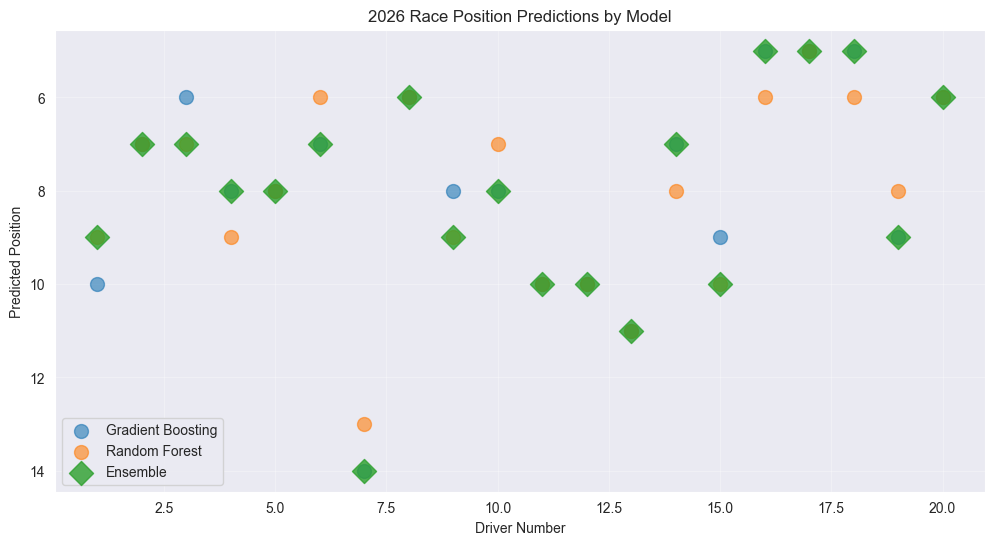

In [11]:
# Visualize predictions
plt.figure(figsize=(12, 6))

x = predictions_2026['driver_number']
plt.scatter(x, predictions_2026['gb_prediction'], label='Gradient Boosting', alpha=0.6, s=100)
plt.scatter(x, predictions_2026['rf_prediction'], label='Random Forest', alpha=0.6, s=100)
plt.scatter(x, predictions_2026['ensemble_prediction'], label='Ensemble', alpha=0.8, s=150, marker='D')

plt.xlabel('Driver Number')
plt.ylabel('Predicted Position')
plt.title('2026 Race Position Predictions by Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Lower position number = better
plt.show()

## 6. Save Models and Predictions to Database

In [12]:
# Save trained models
print("Saving models...")
race_model.save_models('f1_race_model')
quali_model.save_models('f1_quali_model')
sprint_model.save_models('f1_sprint_model')

print("\n✓ All models saved successfully")

Saving models...
✓ Saved Gradient Boosting model: E:\Formula_1_db\notebooks\..\models\f1_race_model_gb.pkl
✓ Saved Random Forest model: E:\Formula_1_db\notebooks\..\models\f1_race_model_rf.pkl
✓ All models saved successfully
✓ Saved Gradient Boosting model: E:\Formula_1_db\notebooks\..\models\f1_quali_model_gb.pkl
✓ Saved Random Forest model: E:\Formula_1_db\notebooks\..\models\f1_quali_model_rf.pkl
✓ All models saved successfully
✓ Saved Gradient Boosting model: E:\Formula_1_db\notebooks\..\models\f1_sprint_model_gb.pkl
✓ Saved Random Forest model: E:\Formula_1_db\notebooks\..\models\f1_sprint_model_rf.pkl
✓ All models saved successfully

✓ All models saved successfully


In [13]:
# Store predictions in database
print("Storing predictions in database...")

# Create a dummy race entry for 2026
race_id = db.insert_race(
    year=2026,
    round_number=1,
    event_name='2026 Season Opener (Predicted)',
    country='TBD',
    location='TBD',
    event_date='2026-03-15'
)

if race_id:
    # Store each prediction
    for _, row in predictions_2026.iterrows():
        features = {
            'driver_number': int(row['driver_number']),
            'gb_prediction': int(row['gb_prediction']),
            'rf_prediction': int(row['rf_prediction'])
        }
        
        db.insert_prediction(
            race_id=race_id,
            session_type='Race',
            driver_number=int(row['driver_number']),
            predicted_position=int(row['ensemble_prediction']),
            confidence=float(row['confidence']),
            model_type='ensemble',
            features=features
        )
    
    print(f"✓ Stored {len(predictions_2026)} predictions for race_id {race_id}")
else:
    print("Error: Could not create race entry")

Storing predictions in database...
✓ Stored 20 predictions for race_id 104


## 7. Model Summary

In [14]:
print("="*60)
print("F1 PREDICTION SYSTEM - MODEL SUMMARY")
print("="*60)

print("\n📊 MODELS TRAINED:")
print("  1. Race Position Prediction (Gradient Boosting + Random Forest)")
print("  2. Qualifying Position Prediction (Gradient Boosting + Random Forest)")
print("  3. Sprint Race Prediction (Gradient Boosting + Random Forest)")

print("\n🎯 PREDICTION TYPES:")
print("  - Qualifying Results")
print("  - Sprint Race Results")
print("  - Main Race Results")
print("  - 2026 Season Predictions")

print("\n💾 STORAGE:")
print("  - Models saved to: models/")
print("  - Predictions stored in SQLite database")
print("  - Feature importance exported for explainability")

print("\n🎨 VISUALIZATION:")
print("  - Feature importance charts generated")
print("  - Prediction comparison plots created")
print("  - Launch Streamlit app to explore interactively")

print("\n✅ READY FOR DEPLOYMENT:")
print("  Run: streamlit run src/streamlit_app.py")

print("\n" + "="*60)

F1 PREDICTION SYSTEM - MODEL SUMMARY

📊 MODELS TRAINED:
  1. Race Position Prediction (Gradient Boosting + Random Forest)
  2. Qualifying Position Prediction (Gradient Boosting + Random Forest)
  3. Sprint Race Prediction (Gradient Boosting + Random Forest)

🎯 PREDICTION TYPES:
  - Qualifying Results
  - Sprint Race Results
  - Main Race Results
  - 2026 Season Predictions

💾 STORAGE:
  - Models saved to: models/
  - Predictions stored in SQLite database
  - Feature importance exported for explainability

🎨 VISUALIZATION:
  - Feature importance charts generated
  - Prediction comparison plots created
  - Launch Streamlit app to explore interactively

✅ READY FOR DEPLOYMENT:
  Run: streamlit run src/streamlit_app.py

